In [1]:
import os
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import clipboard
import base64
from io import BytesIO
from PIL import Image
from proxyattention.meta_utils import read_pickle, return_grouped_results

import seaborn as sns
pd.set_option('display.max_rows', 500)
# plt.switch_backend('Agg')
%matplotlib inline
sns.set_palette("Set2")


/home/eragon/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
!python result_aggregator.py -i

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3196.88it/s]


In [2]:
restored_df = read_pickle(fname = "./results/restored_runs.csv")[0]

In [3]:
restored_df.shape

(611, 39)

In [4]:
combined_df = read_pickle(fname = "./results/aggregated_runs.csv")[0]


In [5]:
combined_df.shape

(1574, 41)

In [6]:
combined_df = pd.concat([combined_df, restored_df], axis = 0)
combined_df.shape

(2185, 41)

# Continue here

In [7]:
combined_df["ds_name"].unique()

array([nan, 'tsing', 'cifar100', 'dogs', 'places256', 'plantdisease',
       'asl', 'caltech101', 'fer'], dtype=object)

In [8]:
combined_df[combined_df["global_run_count"]!= "0"]["proxy_steps"].value_counts()

proxy_steps
[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]    1897
[20, 'p', 19]                           161
[40]                                     61
Name: count, dtype: int64

In [9]:
combined_df["experiment_name"].value_counts()

experiment_name
hypers          950
transform       765
proxy_run       384
paper_extras     20
Name: count, dtype: int64

# Preprocess

In [10]:
def check_proxy(string): return "p" in str(string)

In [11]:
def calc_stats(values):
    return f"min: {values.min()} \nmax: {values.max()} \navg: {values.mean()}"

In [12]:
def convert_float(df, cols, totype= float):
    for col in cols:
        df[col] = df[col].astype(totype)

In [13]:
combined_df = combined_df.fillna(0)
# col to check for proxy
# combined_df["has_proxy"] = combined_df["proxy_steps"].apply(check_proxy)
# Fix naming
combined_df = combined_df.rename(columns={"Acc/Val":"accuracy", "proxy_steps":"step_schedule"})
# Fix types
convert_float(combined_df, ["change_subset_attention", "proxy_threshold", "accuracy"], float)
convert_float(combined_df, ["global_run_count"], int)
convert_float(combined_df, ["transfer_imagenet"], bool)

# ignore failed runs
combined_df = combined_df[combined_df["ds_name"]!="0"]
combined_df = combined_df[combined_df["global_run_count"]!=0]


In [14]:
combined_df["has_proxy"] = combined_df["step_schedule"].apply(check_proxy)

In [15]:
combined_df["global_run_count"].unique()

array([ 5,  6, 15, 16, 25, 26, 35, 36, 40, 20, 21, 22,  1, 14,  8,  7,  4])

In [16]:
# combined_df = combined_df[combined_df["global_run_count"].astype(int) < 10]

In [17]:
combined_df.loc[combined_df["has_proxy"] == False, ["pixel_replacement_method", "gradient_method"]] = "baseline"

# Paper Results

## By Dataset

In [19]:
def return_grouped_results(
    df,
    group_cols,
    filter=None,
    map = None,
    index_cols=(["ds_name", ("accuracy")]),
    print_latex=False,
    save_latex=None,
    caption=None,
    label=None,
    format_size = None,
):
    df = df.copy()
    if map is not None:
        df[map[0]] = df[map[0]].map(map[1])
    if filter != None:
        df = df.reset_index()
        for key in filter.keys():
            df = df[df[key] == filter[key]]
    final_df = pd.DataFrame(
        df.groupby(group_cols, as_index=True).mean(numeric_only=True)["accuracy"]
    ).sort_values(index_cols, ascending=False)
    if print_latex == True:
        clipboard.copy(final_df.to_latex())
    if save_latex is not None:
        temp_latex = "\\begin{table}[H]\n"
        temp_latex += "\centering\n"
        if format_size is not None:
            temp_latex += "\\resizebox{" + str(format_size) +  "\\columnwidth}{!}{%\n"
        else:
            temp_latex += "\\resizebox{\\columnwidth}{!}{\n"
        temp_latex += final_df.to_latex()
        # temp_latex += "\end{tabular}%\\}"
        temp_latex += "}\n"
        temp_latex += "\caption{" + caption + "}" + "\n"
        temp_latex += "\label{" + str(label) + "}" + "\n"
        temp_latex += "\end{table}"
        with open(save_latex, "w+") as f:
            f.write(temp_latex)
    return final_df

In [20]:

temp_results = return_grouped_results(combined_df, ["ds_name","model", "step_schedule"],filter={"ds_name" :"fer"}, map = ("step_schedule", {"[20, 'p', 19]":"Proxy", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"Proxy", "[40]":"No Proxy"}))
temp_results

accuracy
ds_name model           step_schedule           
fer     efficientnet_b0 Proxy          85.814444
                        No Proxy       76.860001

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

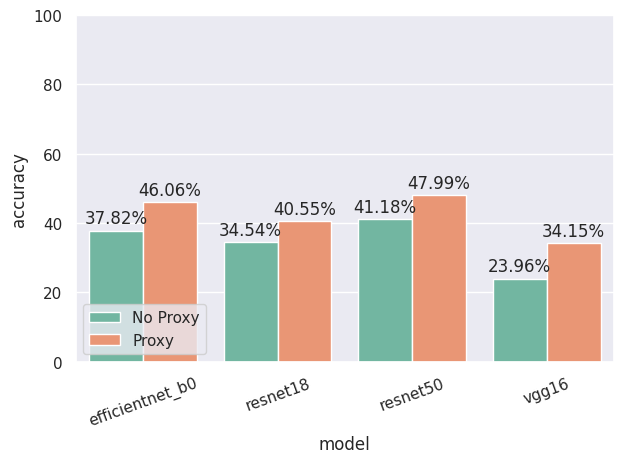

In [196]:
for dataset in tqdm(['dogs','cifar100', 'asl', 'plantdisease', 'caltech101', 'tsing', 'places256']):
    plt.rcParams["figure.autolayout"] = True
    if not dataset == "places256":
        temp_results = return_grouped_results(combined_df, ["ds_name","model", "step_schedule"],filter={"ds_name" :dataset}, map = ("step_schedule", {"[20, 'p', 19]":"Proxy", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"Proxy", "[40]":"No Proxy"}))
    else:
        temp_res = return_grouped_results(combined_df, ["ds_name","model", "step_schedule"],filter={"ds_name" :"places256"}, map = ("step_schedule", {"[20, 'p', 19]":"Proxy", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"Proxy", "[40]":"No Proxy"})).reset_index()
        temp_res = temp_res[temp_res["model"] != "vit_base_patch16_224"]
        temp_results = temp_res.groupby(["ds_name", "model", "step_schedule"]).mean()
    plt.cla()
    plt.clf()
    fig, ax = plt.subplots()
    splot = sns.barplot(data=temp_results.reset_index(), x="model", y="accuracy", hue="step_schedule", errorbar="sd")
    if dataset in ["asl", "plantdisease"]:
        set_format = '.2f'
        plt.ylim([95, 100])
    else:
        set_format = '.2f'
        plt.ylim([0, 100])
    for g in splot.patches:
        splot.annotate(format(g.get_height(), set_format)+ "%",
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

    if not dataset == "places256":
        plt.xticks(ticks = np.arange(0, 5), rotation = 20, labels=["ResNet50","EfficientNetB0", "ResNet18", "ViT Base 16x224", "VGG16"])
    else:
        plt.xticks(rotation = 20)
    plt.legend(loc='lower left')
    # break
    plt.savefig(f"../writing/thesis/results/{dataset}_results.pdf", transparent=True)
    # except:
    #     pass

In [22]:
# Generate string for latex
ds_text = """\subsection{%s Results}
This section shows the accuracies per model for the %s dataset. The results are shown in Figure \\ref{fig:%s_results}. 
\\begin{figure}[H]
    \centering
    \includegraphics[width=1\\textwidth]{results/%s_results.pdf}
    \caption{Comparing Accuracies of models trained with and without Proxy Attention on the %s dataset}
    \label{fig:%s_results}
\end{figure}
""" 
full_string = ""
for ds in ['tsing', 'places256','dogs','cifar100', 'caltech101','asl', 'plantdisease']:
    full_string += ds_text % tuple([ds.capitalize(),ds.capitalize(),ds, ds, ds.capitalize(), ds])
    full_string += "\n"
# print(full_string)
clipboard.copy(full_string)

# Group per step Schedule

In [23]:
temp_results = return_grouped_results(combined_df, ["ds_name", "step_schedule","model"], save_latex="../writing/thesis/results/schedule_resnet50.tex", caption="Accuracy grouped by Schedule for ResNet50", label="tab:gpschedulere", filter={"model":"efficientnet_b0"}, map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}))
temp_results

accuracy
ds_name      step_schedule     model                     
tsing        5,p,9,p,9,p,9,p,4 efficientnet_b0  81.651429
             20,p,19           efficientnet_b0  78.096667
             No Proxy          efficientnet_b0  72.880001
plantdisease 5,p,9,p,9,p,9,p,4 efficientnet_b0  99.101112
             No Proxy          efficientnet_b0  98.900002
             20,p,19           efficientnet_b0  98.680000
places256    5,p,9,p,9,p,9,p,4 efficientnet_b0  46.376552
             20,p,19           efficientnet_b0  43.026666
             No Proxy          efficientnet_b0  37.815001
fer          5,p,9,p,9,p,9,p,4 efficientnet_b0  85.814444
             No Proxy          efficientnet_b0  76.860001
dogs         5,p,9,p,9,p,9,p,4 efficientnet_b0  94.285901
             20,p,19           efficientnet_b0  90.973824
             No Proxy          efficientnet_b0  85.645507
cifar100     5,p,9,p,9,p,9,p,4 efficientnet_b0  81.665000
             20,p,19           efficientnet_b0  79.037500
             No Proxy          efficientnet_b0  75.220001
caltech101   5,p,9,p,9,p,9,p,4 efficientnet_b0  97.773901
             20,p,19           efficientnet_b0  96.697289
             No Proxy          efficientnet_b0  94.313210
asl          No Proxy          efficientnet_b0  99.949997
             20,p,19           efficientnet_b0  99.903330
             5,p,9,p,9,p,9,p,4 efficientnet_b0  99.844443

<Figure size 640x480 with 0 Axes>

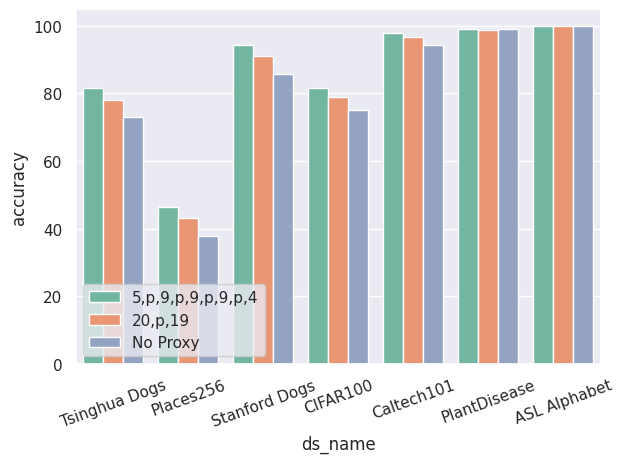

In [24]:
plt.cla()
plt.clf()
fig, ax = plt.subplots()
# splot = sns.barplot(data=temp_results.reset_index(), x="ds_name", y="accuracy", hue="step_schedule", errorbar="sd", order=['dogs','cifar100', 'caltech101','plantdisease','asl'])
splot = sns.barplot(data=temp_results.reset_index(), x="ds_name", y="accuracy", hue="step_schedule", errorbar="sd", order=['tsing', 'places256', 'dogs','cifar100', 'caltech101','plantdisease','asl'])
# plt.xticks(rotation = 15)
# ax.bar_label(ax.containers[0])
# for g in splot.patches:
#     splot.annotate(format(g.get_height(), '.2f'),
#                 (g.get_x() + g.get_width() / 2., g.get_height()),
#                 ha = 'center', va = 'center',
#                 xytext = (0, 9),
#                 textcoords = 'offset points')
plt.legend(loc='lower left')
plt.xticks(ticks = np.arange(0, 7), rotation = 20, labels = ['Tsinghua Dogs', 'Places256', 'Stanford Dogs', 'CIFAR100', 'Caltech101', 'PlantDisease', 'ASL Alphabet'])
plt.savefig(f"../writing/thesis/results/schedule_resnet50.pdf", transparent=True)

# Time taken

In [25]:
combined_df.columns

Index(['index', 'proxy_step', 'Loss/Train', 'Acc/Train', 'global_run_count',
       'Loss/Val', 'accuracy', 'experiment_name', 'image_size', 'batch_size',
       'enable_proxy_attention', 'transfer_imagenet', 'subset_images',
       'pixel_replacement_method', 'load_proxy_data', 'log_every', 'device',
       'dataset_info', 'main_run_dir', 'change_subset_attention', 'model',
       'proxy_image_weight', 'proxy_threshold', 'gradient_method', 'ds_name',
       'clear_every_step', 'step_schedule', 'fname_start', 'ds_path',
       'name_fn', 'writer', 'label_map', 'rev_label_map', 'num_classes',
       'dataset_sizes', 'criterion', 'save_path', 'final_acc', 'Number_Chosen',
       'Time_Proxy', 'Classification Report', 'has_proxy'],
      dtype='object')

In [26]:
# temp_results = return_grouped_results(combined_df, ["ds_name", "step_schedule","model"], save_latex="../writing/thesis/results/schedule_resnet50.tex", caption="Accuracy grouped by Schedule for ResNet50", label="tab:gpschedulere", filter={"model":"efficientnet_b0"}, map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}))
temp_results = return_grouped_results(combined_df, ["ds_name", "Time_Proxy","model", "Number_Chosen", "batch_size", "gradient_method"], filter={"experiment_name":"paper_extras"}, map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}))
temp_results.reset_index()["Number_Chosen"].mean()

877.5

In [27]:
temp_results.reset_index()["gradient_method"]

0    gradcamplusplus
1    gradcamplusplus
2    gradcamplusplus
3    gradcamplusplus
4    gradcamplusplus
5    gradcamplusplus
6    gradcamplusplus
7    gradcamplusplus
8    gradcamplusplus
9           baseline
Name: gradient_method, dtype: object

In [28]:
temp_results.reset_index()["batch_size"].astype(int).mean()

64.0

In [29]:
# avg total images
avg_total_ims = temp_results.reset_index()["Number_Chosen"].mean() 
avg_bs = 64
time_per_batch = temp_results.reset_index()["Time_Proxy"].mean()
total_time = (avg_total_ims/avg_bs)*time_per_batch
total_time

9.406433262862265

# Subset

In [194]:
temp_results = return_grouped_results(combined_df, ["ds_name", "has_proxy","Time_Proxy","model", "Number_Chosen", "batch_size", "gradient_method",], filter={"ds_name":"places256"}, map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}))

In [195]:
temp_results

accuracy
ds_name   has_proxy Time_Proxy model                Number_Chosen batch_size gradient_method           
places256 True      1.245571   efficientnet_b0      1002.0        64         gradcamplusplus  52.730000
                    0.000000   resnet50             1000.0        32         gradcamplusplus  52.330002
                    1.431299   efficientnet_b0      1011.0        64         gradcamplusplus  51.980000
                    0.000000   resnet50             1045.0        32         gradcamplusplus  51.849998
                               efficientnet_b0      1013.0        64         gradcamplusplus  51.369999
                                                    1043.0        64         gradcamplusplus  51.169998
                    0.661175   efficientnet_b0      1040.0        64         gradcamplusplus  50.750000
                    0.781344   efficientnet_b0      1047.0        64         gradcamplusplus  50.549999
                    0.000000   resnet50             1105.0        32         gradcamplusplus  49.189999
                    0.479342   efficientnet_b0      1095.0        64         gradcamplusplus  48.419998
                    0.000000   efficientnet_b0      1094.0        64         gradcamplusplus  48.160000
                               resnet50             1142.0        32         gradcamplusplus  47.880001
                    0.653754   efficientnet_b0      1103.0        64         gradcamplusplus  47.650002
                    0.000000   resnet50             0.0           32         gradcamplusplus  47.437143
                               efficientnet_b0      1177.0        64         gradcamplusplus  45.139999
                               resnet18             1083.0        128        gradcamplusplus  44.950001
                               efficientnet_b0      0.0           64         gradcamplusplus  44.711579
                               resnet18             1141.0        128        gradcamplusplus  43.869999
                               vit_base_patch16_224 1202.0        16         gradcamplusplus  43.240002
                               resnet50             1250.0        32         gradcamplusplus  42.599998
                    0.864758   efficientnet_b0      1243.0        64         gradcamplusplus  42.560001
                    0.000000   vit_base_patch16_224 1227.0        16         gradcamplusplus  42.500000
                               vgg16                1225.0        16         gradcamplusplus  42.450001
                    0.743290   efficientnet_b0      1234.0        64         gradcamplusplus  42.049999
                    0.000000   efficientnet_b0      1241.0        64         gradcamplusplus  41.950001
                               resnet18             1179.0        128        gradcamplusplus  41.200001
          False     0.000000   resnet50             0.0           32         baseline         41.180000
          True      0.000000   vit_base_patch16_224 1252.0        16         gradcamplusplus  40.439999
                               resnet18             0.0           128        gradcamplusplus  40.311429
                               vgg16                1252.0        16         gradcamplusplus  39.889999
                                                    1312.0        16         gradcamplusplus  38.470001
                               resnet18             1256.0        128        gradcamplusplus  37.939999
          False     0.000000   efficientnet_b0      0.0           64         baseline         37.815001
          True      0.000000   vit_base_patch16_224 1304.0        16         gradcamplusplus  37.689999
                               resnet18             1325.0        128        gradcamplusplus  36.459999
                               vit_base_patch16_224 0.0           16         gradcamplusplus  35.357999
                               vgg16                1370.0        16         gradcamplusplus  35.330002
          False     0.000000   resnet18

# Confusions

In [187]:
temp_results = return_grouped_results(combined_df, ["ds_name", "has_proxy","Time_Proxy","model", "Number_Chosen", "batch_size", "gradient_method", "Classification Report"], filter={"experiment_name":"paper_extras"}, map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}))

In [188]:
temp_results = temp_results.reset_index()

In [189]:
temp_results

,ds_name,has_proxy,Time_Proxy,model,Number_Chosen,batch_size,gradient_method,Classification Report,accuracy
0,places256,True,1.245571,efficientnet_b0,1002.0,64,gradcamplusplus,0,52.730000
1,places256,True,0.000000,efficientnet_b0,0.0,64,gradcamplusplus,precision recall ...,52.709999
2,places256,True,1.431299,efficientnet_b0,1011.0,64,gradcamplusplus,precision recall ...,51.980000
3,places256,True,0.661175,efficientnet_b0,1040.0,64,gradcamplusplus,0,50.750000
4,places256,True,0.781344,efficientnet_b0,1047.0,64,gradcamplusplus,precision recall ...,50.549999
5,places256,True,0.000000,efficientnet_b0,0.0,64,gradcamplusplus,precision recall ...,49.349998
6,places256,True,0.479342,efficientnet_b0,1095.0,64,gradcamplusplus,0,48.419998
7,places256,True,0.000000,efficientnet_b0,0.0,64,gradcamplusplus,precision recall ...,47.770000
8,places256,True,0.653754,efficientnet_b0,1103.0,64,gradcamplusplus,precision recall ...,47.650002
9,places256,True,0.000000,efficientnet_b0,0.0,64,gradcamplusplus,0,46.254000


In [165]:
index = (1, 13)

In [169]:
def parse_classification_report(report):
    report = report.split("\n")[1::]
    report = [x.strip().split("     ") for x in report if len(x)>0]
    report = pd.DataFrame(report)
    report = report[:-4]
    report.columns = ["class", "precision", "recall", "f1-score", "support", "",""]
    return report

In [170]:
lowest_initial_precision = parse_classification_report(temp_results["Classification Report"][index[0]]).sort_values(by="precision", ascending=True).iloc[0]

In [172]:
lowest_initial_precision

class        mountain
precision        0.12
recall           0.14
f1-score         0.13
support            57
                 None
                 None
Name: 109, dtype: object

In [179]:
lowest_initial_precision = parse_classification_report(temp_results["Classification Report"][13]).sort_values(by="precision", ascending=True)

In [180]:
lowest_initial_precision

,class,precision,recall,f1-score,support,,
85,hospital,0.00,0.00,0.00,56,None,None
23,beauty_salon,0.00,0.00,0.00,25,None,None
94,kasbah,0.00,0.00,0.00,27,None,None
173,waiting_room,0.00,0.00,0.00,30,None,None
107,medina,0.00,0.00,0.00,34,None,None
158,snowfield,0.00,0.00,0.00,23,None,None
135,reception,0.00,0.00,0.00,25,None,None
34,butchers_shop,0.00,0.00,0.00,17,None,None
36,cafeteria,0.00,0.00,0.00,21,None,None
112,nursery,0.00,0.00,0.00,36,None,None


In [151]:
temp_results.reset_index()["Classification Report"].shape

(16,)

In [ ]:
def iterate_and_combine_cm(temp_results)

# 

# Results grouped by Proxy Threshold 

In [63]:
combined_df.columns

Index(['index', 'proxy_step', 'Loss/Train', 'Acc/Train', 'global_run_count',
       'Loss/Val', 'accuracy', 'experiment_name', 'image_size', 'batch_size',
       'enable_proxy_attention', 'transfer_imagenet', 'subset_images',
       'pixel_replacement_method', 'load_proxy_data', 'log_every', 'device',
       'dataset_info', 'main_run_dir', 'change_subset_attention', 'model',
       'proxy_image_weight', 'proxy_threshold', 'gradient_method', 'ds_name',
       'clear_every_step', 'step_schedule', 'fname_start', 'ds_path',
       'name_fn', 'writer', 'label_map', 'rev_label_map', 'num_classes',
       'dataset_sizes', 'criterion', 'save_path', 'final_acc', 'Number_Chosen',
       'has_proxy'],
      dtype='object')

In [24]:
temp_results = return_grouped_results(combined_df, ["ds_name", "proxy_threshold","model" ], 
save_latex="../writing/thesis/results/proxy_threshold_effnetb0.tex", 
# save_latex = None,
caption="Accuracy grouped by Proxy Threshold for EfficientNetB0", label="tab:proxy_threshold", map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}),filter={"model":"efficientnet_b0", "ds_name":"dogs"})
temp_results

accuracy
ds_name proxy_threshold model                     
dogs    0.80            efficientnet_b0  94.206487
        0.40            efficientnet_b0  94.158751
        0.10            efficientnet_b0  94.156481
        0.85            efficientnet_b0  93.998734

<Figure size 640x480 with 0 Axes>

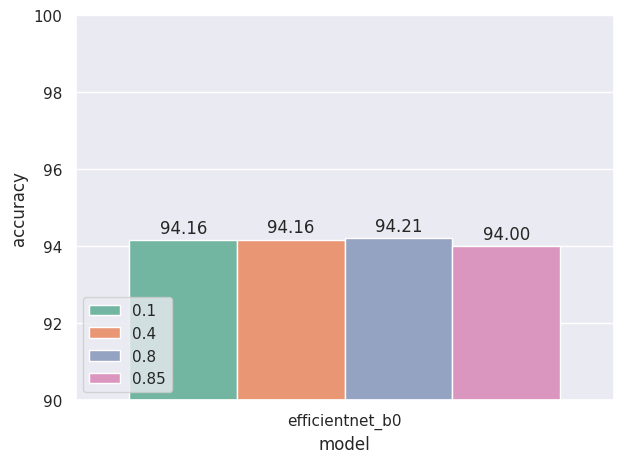

In [25]:
plt.cla()
plt.clf()
fig, ax = plt.subplots()
splot = sns.barplot(data=temp_results.reset_index(), x="model", y="accuracy",  errorbar="sd", hue="proxy_threshold")
plt.ylim([90, 100])
# ax.bar_label(ax.containers[0])
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"../writing/thesis/results/proxy_threshold_results.pdf", transparent=True)

<Figure size 640x480 with 0 Axes>

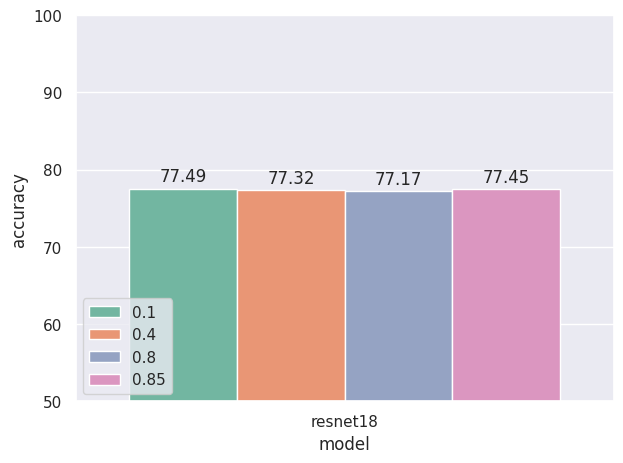

In [26]:
temp_results = return_grouped_results(combined_df, ["ds_name", "proxy_threshold","model" ], 
save_latex="../writing/thesis/results/proxy_threshold_tsing_res.tex", 
# save_latex = None,
caption="Accuracy grouped by Proxy Threshold for ResNet18 on the Tsinghua Dogs Dataset", label="tab:proxy_threshold", map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}),filter={"model":"resnet18", "ds_name":"tsing"})
temp_results
plt.cla()
plt.clf()
fig, ax = plt.subplots()
splot = sns.barplot(data=temp_results.reset_index(), x="model", y="accuracy",  errorbar="sd", hue="proxy_threshold")
plt.ylim([50, 100])
# ax.bar_label(ax.containers[0])
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"../writing/thesis/results/proxy_threshold_results_tsing.pdf", transparent=True)

# Grouped by proxy_image_weight

In [27]:
temp_results = return_grouped_results(combined_df, ["ds_name", "proxy_image_weight","model" ], 
save_latex="../writing/thesis/results/proxy_weight_effnetb0.tex", 
# save_latex = None,
caption="Accuracy grouped by Proxy Weight for EfficientNetB0", label="tab:proxy_weight", map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}),filter={"ds_name":"dogs", "model":"efficientnet_b0"})
temp_results

accuracy
ds_name proxy_image_weight model                     
dogs    0.1                efficientnet_b0  94.263459
        0.8                efficientnet_b0  94.179906
        0.95               efficientnet_b0  94.156435
        0.4                efficientnet_b0  94.040084
        0.2                efficientnet_b0  92.618603

<Figure size 640x480 with 0 Axes>

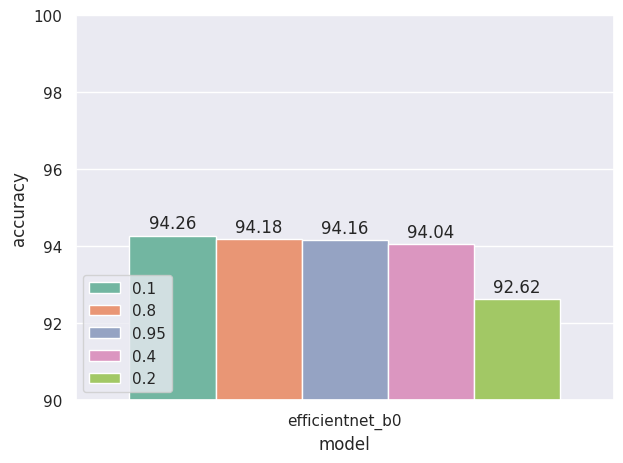

In [28]:
plt.cla()
plt.clf()
fig, ax = plt.subplots()
splot = sns.barplot(data=temp_results.reset_index(), x="model", y="accuracy",  errorbar="sd", hue="proxy_image_weight", )
# ax.bar_label(ax.containers[0])
plt.ylim([90, 100])

for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"../writing/thesis/results/proxy_weight_results.pdf", transparent=True)

<Figure size 640x480 with 0 Axes>

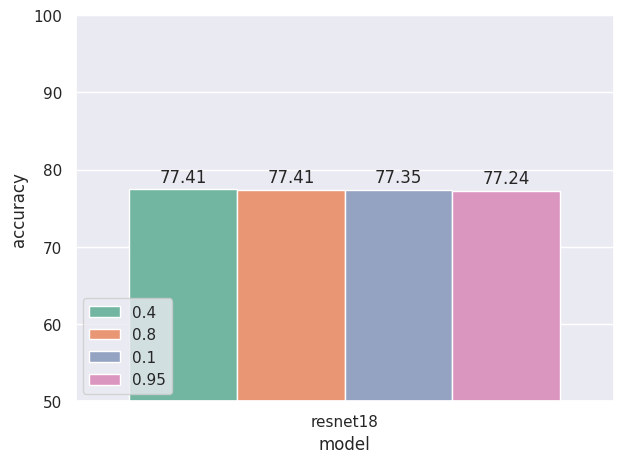

In [31]:
temp_results = return_grouped_results(combined_df, ["ds_name", "proxy_image_weight","model" ], 
save_latex="../writing/thesis/results/proxy_weight_tsing_res.tex", 
# save_latex = None,
caption="Accuracy grouped by Proxy Image Weights for ResNet18 on the Tsinghua Dogs Dataset", label="tab:proxy_weight2", map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}),filter={"model":"resnet18", "ds_name":"tsing"})
temp_results
plt.cla()
plt.clf()
fig, ax = plt.subplots()
splot = sns.barplot(data=temp_results.reset_index(), x="model", y="accuracy",  errorbar="sd", hue="proxy_image_weight")
plt.ylim([50, 100])
# ax.bar_label(ax.containers[0])
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"../writing/thesis/results/proxy_weight_results_tsing.pdf", transparent=True)

# Grouped by subset_attention   

In [33]:
temp_results = return_grouped_results(combined_df, ["ds_name", "change_subset_attention","model" ], 
save_latex="../writing/thesis/results/proxy_subset_attention_effnetb0.tex", 
# save_latex = None,
caption="Accuracy grouped by subset (\%) of images used for Proxy Attention for EfficientNetB0", label="tab:proxy_weight", map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}),filter={"ds_name":"dogs", "model":"efficientnet_b0"})
temp_results

accuracy
ds_name change_subset_attention model                     
dogs    0.20                    efficientnet_b0  94.728643
        0.95                    efficientnet_b0  94.033266
        0.80                    efficientnet_b0  93.720798

<Figure size 640x480 with 0 Axes>

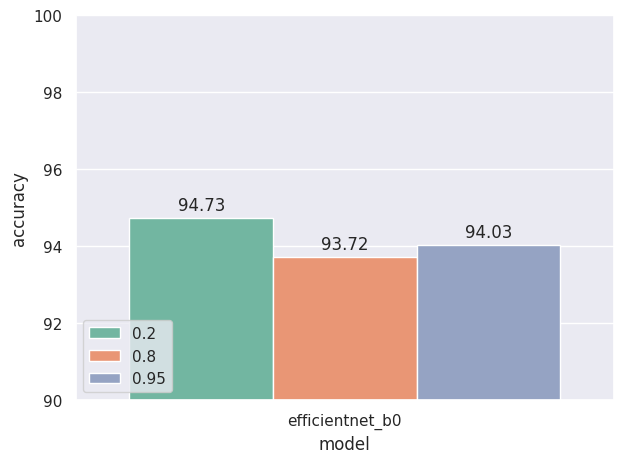

In [34]:
plt.cla()
plt.clf()
fig, ax = plt.subplots()
splot = sns.barplot(data=temp_results.reset_index(), x="model", y="accuracy",  errorbar="sd", hue="change_subset_attention", )
# ax.bar_label(ax.containers[0])
plt.ylim([90, 100])
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"../writing/thesis/results/proxy_subset_attention_results.pdf", transparent=True)

<Figure size 640x480 with 0 Axes>

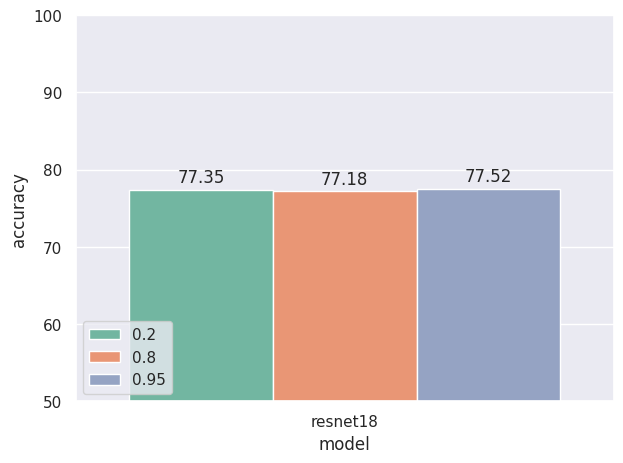

: 

In [35]:
temp_results = return_grouped_results(combined_df, ["ds_name", "change_subset_attention","model" ], 
save_latex="../writing/thesis/results/proxy_subset_tsing_res.tex", 
# save_latex = None,
caption="Accuracy grouped by Proxy Image Subsets for ResNet18 on the Tsinghua Dogs Dataset", label="tab:proxy_subset2", map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}),filter={"model":"resnet18", "ds_name":"tsing"})
temp_results
plt.cla()
plt.clf()
fig, ax = plt.subplots()
splot = sns.barplot(data=temp_results.reset_index(), x="model", y="accuracy",  errorbar="sd", hue="change_subset_attention")
plt.ylim([50, 100])
# ax.bar_label(ax.containers[0])
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"../writing/thesis/results/proxy_subset_results_tsing.pdf", transparent=True)

# Extrasc

In [37]:
return_grouped_results(combined_df, ["experiment_name","ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"], save_latex="/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/test.tex", caption="Test", label="test")

/var/folders/s2/psn1kzxd2_972xy94t5fr4cr0000gn/T/ipykernel_33629/1666816244.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  temp_latex += final_df.to_latex() + "\n"


accuracy
experiment_name ds_name      pixel_replacement_method transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model                proxy_image_weight           
proxy_run       plantdisease blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet18             0.2                 99.147778
                                                                                                                                                                    efficientnet_b0      0.2                 99.101112
                                                                                        [20, 'p', 19]                       0.80                    0.85            resnet50             0.2                 99.023333
                             baseline                 True              baseline        [40]                                0.80                    0.85            resnet18             0.2                 98.949997
                                                                                                                                                                    resnet50             0.2                 98.949997
                                                                                                                                                                    efficientnet_b0      0.2                 98.900002
                             blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85            resnet18             0.2                 98.826668
                                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet50             0.2                 98.786666
                                                                                        [20, 'p', 19]                       0.80                    0.85            efficientnet_b0      0.2                 98.680000
                dogs         blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85            resnet50             0.2                 95.497701
                                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet50             0.2                 95.495351
hypers          dogs         blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                    0.80            efficientnet_b0      0.8                 94.985541
                                                                                                                                                    0.10            efficientnet_b0      0.1                 94.911736
                                                                                                                                                    0.40            efficientnet_b0      0.95                94.890021
                                                                                                                                                                                         0.1                 94.845623
                                                                                                                                                    0.10            efficientnet_b0      0.8                 94.786770
                                                                                                                                                    0.40            efficientnet_b0      0.8                 94.782388
                                                                                                                         

In [15]:
return_grouped_results(combined_df, ["experiment_name","ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"])

accuracy
experiment_name ds_name      pixel_replacement_method transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model                proxy_image_weight           
proxy_run       plantdisease blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet18             0.2                 99.147778
                                                                                                                                                                    efficientnet_b0      0.2                 99.101112
                                                                                        [20, 'p', 19]                       0.80                    0.85            resnet50             0.2                 99.023333
                             baseline                 True              baseline        [40]                                0.80                    0.85            resnet18             0.2                 98.949997
                                                                                                                                                                    resnet50             0.2                 98.949997
                                                                                                                                                                    efficientnet_b0      0.2                 98.900002
                             blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85            resnet18             0.2                 98.826668
                                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet50             0.2                 98.786666
                                                                                        [20, 'p', 19]                       0.80                    0.85            efficientnet_b0      0.2                 98.680000
                dogs         blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85            resnet50             0.2                 95.497701
                                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet50             0.2                 95.495351
hypers          dogs         blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                    0.80            efficientnet_b0      0.8                 94.985541
                                                                                                                                                    0.10            efficientnet_b0      0.1                 94.911736
                                                                                                                                                    0.40            efficientnet_b0      0.95                94.890021
                                                                                                                                                                                         0.1                 94.845623
                                                                                                                                                    0.10            efficientnet_b0      0.8                 94.786770
                                                                                                                                                    0.40            efficientnet_b0      0.8                 94.782388
                                                                                                                         

In [30]:

return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"], filter={"experiment_name": "transform"})

accuracy
ds_name pixel_replacement_method transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model                proxy_image_weight           
dogs    blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.8                     0.80            vit_base_patch16_224 0.1                 86.055481
                                                                                                                               0.40            vit_base_patch16_224 0.1                 84.646194
                                                                                                                               0.10            vit_base_patch16_224 0.1                 83.396380
                                                                   [20, 'p', 19]                       0.8                     0.80            vit_base_patch16_224 0.1                 77.851952
                                                                                                                               0.10            vit_base_patch16_224 0.1                 77.555257
                                                                                                                               0.40            vit_base_patch16_224 0.1                 76.939624
        baseline                 True              baseline        [40]                                0.8                     0.10            vit_base_patch16_224 0.1                 71.562080
                                                                                                                               0.85            vit_base_patch16_224 0.1                 66.777924
                                                                                                                               0.80            vit_base_patch16_224 0.1                 65.242546
                                                                                                                               0.40            vit_base_patch16_224 0.1                 60.703159

In [31]:
return_grouped_results(combined_df, ["ds_name","model", "gradient_method", "step_schedule", "change_subset_attention"])

accuracy
ds_name      model                gradient_method step_schedule                       change_subset_attention           
plantdisease resnet18             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     99.147778
             efficientnet_b0      gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     99.101112
             resnet50             gradcamplusplus [20, 'p', 19]                       0.80                     99.023333
             resnet18             baseline        [40]                                0.80                     98.949997
             resnet50             baseline        [40]                                0.80                     98.949997
             efficientnet_b0      baseline        [40]                                0.80                     98.900002
             resnet18             gradcamplusplus [20, 'p', 19]                       0.80                     98.826668
             resnet50             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     98.786666
             efficientnet_b0      gradcamplusplus [20, 'p', 19]                       0.80                     98.680000
dogs         resnet50             gradcamplusplus [20, 'p', 19]                       0.80                     95.497701
                                                  [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     95.495351
             efficientnet_b0      gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                     94.672288
                                                                                      0.80                     93.442382
                                                                                      0.95                     93.339572
             resnet50             baseline        [40]                                0.80                     92.011574
             efficientnet_b0      gradcamplusplus [20, 'p', 19]                       0.80                     91.410772
             resnet18             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     87.411429
                                  gradcam         [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     86.384286
             efficientnet_b0      baseline        [40]                                0.80                     85.825546
             vit_base_patch16_224 gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     84.569055
             resnet18             gradcam         [20, 'p', 19]                       0.80                     80.473335
             vit_base_patch16_224 gradcamplusplus [20, 'p', 19]                       0.80                     77.448944
             resnet18             baseline        [40]                                0.80                     71.414997
             vit_base_patch16_224 baseline        [40]                                0.80                     66.071427
cifar100     resnet50             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     83.106666
                                                  [20, 'p', 19]                       0.80                     82.090001
             efficientnet_b0      gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     81.665000
                                                  [20, 'p', 19]                       0.80                     79.037500
             resnet50             baseline        [40]                                0.80                     78.699997
             resnet18             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     76.778000
                                                  [20, 'p', 19]                       0.80                     75.559998
             efficientnet_b0      baseline        [40]                                0.80                     75.22000

In [43]:
return_grouped_results(combined_df, ["ds_name", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"], filter = { "ds_name":"plantdisease"})

accuracy
ds_name      transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model           proxy_image_weight           
plantdisease True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.8                     0.85            resnet18        0.2                 99.147778
                                                                                                                           efficientnet_b0 0.2                 99.101112
                                               [20, 'p', 19]                       0.8                     0.85            resnet50        0.2                 99.023333
                               baseline        [40]                                0.8                     0.85            resnet18        0.2                 98.949997
                                                                                                                           resnet50        0.2                 98.949997
                                                                                                                           efficientnet_b0 0.2                 98.900002
                               gradcamplusplus [20, 'p', 19]                       0.8                     0.85            resnet18        0.2                 98.826668
                                               [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.8                     0.85            resnet50        0.2                 98.786666
                                               [20, 'p', 19]                       0.8                     0.85            efficientnet_b0 0.2                 98.680000

In [44]:
return_grouped_results(combined_df, ["ds_name", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"], filter = {"model":"efficientnet_b0"})

accuracy
ds_name      transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model           proxy_image_weight           
plantdisease True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            efficientnet_b0 0.2                 99.101112
                               baseline        [40]                                0.80                    0.85            efficientnet_b0 0.2                 98.900002
                               gradcamplusplus [20, 'p', 19]                       0.80                    0.85            efficientnet_b0 0.2                 98.680000
dogs         True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                    0.80            efficientnet_b0 0.8                 94.985541
                                                                                                           0.10            efficientnet_b0 0.1                 94.911736
                                                                                                           0.40            efficientnet_b0 0.95                94.890021
                                                                                                                                           0.1                 94.845623
                                                                                                           0.10            efficientnet_b0 0.8                 94.786770
                                                                                                           0.40            efficientnet_b0 0.8                 94.782388
                                                                                                           0.85            efficientnet_b0 0.4                 94.762321
                                                                                                           0.10            efficientnet_b0 0.4                 94.737558
                                                                                                           0.80            efficientnet_b0 0.1                 94.723004
                                                                                                           0.85            efficientnet_b0 0.1                 94.658141
                                                                                                                                           0.8                 94.612412
                                                                                                           0.10            efficientnet_b0 0.95                94.565847
                                                                                                           0.80            efficientnet_b0 0.4                 94.493133
                                                                                                           0.40            efficientnet_b0 0.4                 94.491127
                                                                                                           0.80            efficientnet_b0 0.95                94.342921
                                                                                   0.80                    0.10            efficientnet_b0 0.1                 94.259889
                                                                                   0.20                    0.85            efficientnet_b0 0.95                94.168065
                                                                                   0.80                    0.40            efficientnet_b0 0.1                 94.059174
                                                                                                           0.80            efficientnet_b0 0.1                 93.934564
                                                                                                        

In [46]:

return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold"], filter = { "model":"efficientnet_b0", "has_proxy":True,})

accuracy
ds_name      pixel_replacement_method transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold           
plantdisease blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85             99.101112
                                                                        [20, 'p', 19]                       0.80                    0.85             98.680000
dogs         blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                    0.40             94.752290
                                                                                                                                    0.10             94.750478
                                                                                                                                    0.80             94.636150
                                                                                                                                    0.85             94.550235
                                                                                                            0.95                    0.10             93.690255
                                                                                                            0.80                    0.85             93.499807
                                                                                                                                    0.10             93.437621
                                                                                                            0.95                    0.40             93.428386
                                                                                                            0.80                    0.80             93.428107
                                                                                                                                    0.40             93.389638
                                                                                                            0.95                    0.80             93.363819
                                                                                                                                    0.85             92.817858
                                                                        [20, 'p', 19]                       0.80                    0.85             91.410772
cifar100     blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85             81.665000
                                                                        [20, 'p', 19]                       0.80                    0.85             79.037500
caltech101   blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85             97.773901
                                                                        [20, 'p', 19]                       0.80                    0.85             96.697289
asl          blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85             99.903330
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85             99.844443

In [47]:
return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "model"])

accuracy
ds_name      pixel_replacement_method transfer_imagenet gradient_method step_schedule                       model                          
plantdisease blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet18              99.147778
                                                                                                            efficientnet_b0       99.101112
                                                                        [20, 'p', 19]                       resnet50              99.023333
             baseline                 True              baseline        [40]                                resnet18              98.949997
                                                                                                            resnet50              98.949997
                                                                                                            efficientnet_b0       98.900002
             blended                  True              gradcamplusplus [20, 'p', 19]                       resnet18              98.826668
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet50              98.786666
                                                                        [20, 'p', 19]                       efficientnet_b0       98.680000
dogs         blended                  True              gradcamplusplus [20, 'p', 19]                       resnet50              95.497701
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet50              95.495351
                                                                                                            efficientnet_b0       93.905352
             baseline                 True              baseline        [40]                                resnet50              92.011574
             blended                  True              gradcamplusplus [20, 'p', 19]                       efficientnet_b0       91.410772
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet18              87.411429
                                                        gradcam         [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet18              86.384286
             baseline                 True              baseline        [40]                                efficientnet_b0       85.825546
             blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] vit_base_patch16_224  84.569055
                                                        gradcam         [20, 'p', 19]                       resnet18              80.473335
                                                        gradcamplusplus [20, 'p', 19]                       vit_base_patch16_224  77.448944
             baseline                 True              baseline        [40]                                resnet18              71.414997
                                                                                                            vit_base_patch16_224  66.071427
cifar100     blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet50              83.106666
                                                                        [20, 'p', 19]                       resnet50              82.090001
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] efficientnet_b0       81.665000
                                                                        [20, 'p', 19]                       efficientnet_b0       79.037500
             baseline                 True              baseline        [40]                                resnet50              78.699997
             blended                  True              gradcamplusplus

In [49]:
return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "change_subset_attention", "step_schedule", "proxy_image_weight",  "model", "global_run_count"])

accuracy
ds_name      pixel_replacement_method transfer_imagenet gradient_method change_subset_attention step_schedule                       proxy_image_weight model                global_run_count            
plantdisease blended                  True              gradcamplusplus 0.80                    [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.2                resnet50             40                 99.820000
                                                                                                                                                       efficientnet_b0      35                 99.730003
                                                                                                                                                       resnet18             40                 99.650002
                                                                                                                                                                            25                 99.580002
                                                                                                                                                                            35                 99.519997
                                                                                                                                                       efficientnet_b0      25                 99.510002
                                                                                                                                                                            15                 99.500000
                                                                                                                                                                            40                 99.449997
                                                                                                                                                       resnet18             15                 99.360001
                                                                                                                                                                            26                 99.339996
                                                                                                                                                       resnet50             25                 99.339996
                                                                                                                                                                            35                 99.330002
                                                                                                [20, 'p', 19]                       0.2                resnet18             40                 99.309998
                                                                                                [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.2                efficientnet_b0      36                 99.239998
                                                                                                [20, 'p', 19]                       0.2                resnet50             40                 99.180000
                                                                                                [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.2                resnet50             26                 99.139999
                                                                                                [20, 'p', 19]                       0.2                resnet50             21                 99.089996
                                                                                                [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.2                efficientnet_b0      16                 99.040001
                                                                                                [20, 'p', 19]                       0.2                efficientnet_b0      